In [1]:
%cd /content
!rm -rf penDetect
!git clone https://github.com/nowage/penDetect
%cd penDetect

/content
Cloning into 'penDetect'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 118 (delta 63), reused 76 (delta 32), pack-reused 0
Receiving objects: 100% (118/118), 1.85 MiB | 26.61 MiB/s, done.
Resolving deltas: 100% (63/63), done.
/content/penDetect


In [2]:
!bash install.sh

Cloning into 'darknet'...
remote: Enumerating objects: 13289, done.
remote: Total 13289 (delta 0), reused 0 (delta 0), pack-reused 13289
Receiving objects: 100% (13289/13289), 12.12 MiB | 24.44 MiB/s, done.
Resolving deltas: 100% (9104/9104), done.
mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:910:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void cv_draw_object(imag

In [3]:
%cd /content/darknet

from os import getcwd
from os.path import join
from tensorflow.keras.utils import get_file
with open('data/obj.data', 'w') as out:
  out.write('classes = 3\n')
  out.write('train = data/train.txt\n')
  out.write('valid = data/valid.txt\n')
  out.write('names = data/obj.names\n')
  out.write('backup = backup/')

#write train file (just the image list)
import os

with open('data/train.txt', 'w') as out:
  for img in [f for f in os.listdir('train') if f.endswith('jpg')]:
    out.write('data/obj/' + img + '\n')

#write the valid file (just the image list)
import os

with open('data/valid.txt', 'w') as out:
  for img in [f for f in os.listdir('valid') if f.endswith('jpg')]:
    out.write('data/obj/' + img + '\n')

/content/darknet


In [4]:
#we build config dynamically based on number of classes
#we build iteratively from base config files. This is the same file shape as cfg/yolo-obj.cfg
def file_len(fname):
  with open(fname) as f:
    for i, l in enumerate(f):
      pass
  return i + 1

num_classes = file_len('train/_darknet.labels')
print("writing config for a custom YOLOv4 detector detecting number of classes: " + str(num_classes))

#Instructions from the darknet repo
#change line max_batches to (classes*2000 but not less than number of training images, and not less than 6000), f.e. max_batches=6000 if you train for 3 classes
#change line steps to 80% and 90% of max_batches, f.e. steps=4800,5400
if os.path.exists('./cfg/custom-yolov4-detector.cfg'): os.remove('./cfg/custom-yolov4-detector.cfg')


with open('./cfg/custom-yolov4-detector.cfg', 'a') as f:
  f.write('[net]' + '\n')
  f.write('batch=64' + '\n')
  #####smaller subdivisions help the GPU run faster. 12 is optimal, but you might need to change to 24,36,64####
  f.write('subdivisions=24' + '\n')
  f.write('width=416' + '\n')
  f.write('height=416' + '\n')
  f.write('channels=3' + '\n')
  f.write('momentum=0.949' + '\n')
  f.write('decay=0.0005' + '\n')
  f.write('angle=0' + '\n')
  f.write('saturation = 1.5' + '\n')
  f.write('exposure = 1.5' + '\n')
  f.write('hue = .1' + '\n')
  f.write('\n')
  f.write('learning_rate=0.001' + '\n')
  f.write('burn_in=1000' + '\n')
  ######you can adjust up and down to change training time#####
  ##Darknet does iterations with batches, not epochs####
  max_batches = num_classes*2000
  #max_batches = 2000
  f.write('max_batches=' + str(max_batches) + '\n')
  f.write('policy=steps' + '\n')
  steps1 = .8 * max_batches
  steps2 = .9 * max_batches
  f.write('steps='+str(steps1)+','+str(steps2) + '\n')

#Instructions from the darknet repo
#change line classes=80 to your number of objects in each of 3 [yolo]-layers:
#change [filters=255] to filters=(classes + 5)x3 in the 3 [convolutional] before each [yolo] layer, keep in mind that it only has to be the last [convolutional] before each of the [yolo] layers.

  with open('cfg/yolov4-custom2.cfg', 'r') as f2:
    content = f2.readlines()
    for line in content:
      f.write(line)    
    num_filters = (num_classes + 5) * 3
    f.write('filters='+str(num_filters) + '\n')
    f.write('activation=linear')
    f.write('\n')
    f.write('\n')
    f.write('[yolo]' + '\n')
    f.write('mask = 0,1,2' + '\n')
    f.write('anchors = 12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401' + '\n')
    f.write('classes=' + str(num_classes) + '\n')

  with open('cfg/yolov4-custom3.cfg', 'r') as f3:
    content = f3.readlines()
    for line in content:
      f.write(line)    
    num_filters = (num_classes + 5) * 3
    f.write('filters='+str(num_filters) + '\n')
    f.write('activation=linear')
    f.write('\n')
    f.write('\n')
    f.write('[yolo]' + '\n')
    f.write('mask = 3,4,5' + '\n')
    f.write('anchors = 12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401' + '\n')
    f.write('classes=' + str(num_classes) + '\n')

  with open('cfg/yolov4-custom4.cfg', 'r') as f4:
    content = f4.readlines()
    for line in content:
      f.write(line)    
    num_filters = (num_classes + 5) * 3
    f.write('filters='+str(num_filters) + '\n')
    f.write('activation=linear')
    f.write('\n')
    f.write('\n')
    f.write('[yolo]' + '\n')
    f.write('mask = 6,7,8' + '\n')
    f.write('anchors = 12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401' + '\n')
    f.write('classes=' + str(num_classes) + '\n')
    
  with open('cfg/yolov4-custom5.cfg', 'r') as f5:
    content = f5.readlines()
    for line in content:
      f.write(line)

print("file is written!")    




writing config for a custom YOLOv4 detector detecting number of classes: 1
file is written!


In [5]:
!pwd
!ls yolov4.conv.137

/content/darknet
yolov4.conv.137


In [6]:

!./darknet detector train data/obj.data cfg/custom-yolov4-detector.cfg yolov4.conv.137 -dont_show -map

Streaming output truncated to the last 5000 lines.
 1128: 0.865486, 0.829751 avg loss, 0.001000 rate, 5.773807 seconds, 54144 images, 1.338063 hours left
Loaded: 0.000039 seconds

 (next mAP calculation at 1200 iterations) 
 Last accuracy mAP@0.5 = 30.00 %, best = 30.00 % 
 1129: 0.788697, 0.825646 avg loss, 0.001000 rate, 5.766472 seconds, 54192 images, 1.338668 hours left
Loaded: 0.000034 seconds

 (next mAP calculation at 1200 iterations) 
 Last accuracy mAP@0.5 = 30.00 %, best = 30.00 % 
 1130: 0.626910, 0.805772 avg loss, 0.001000 rate, 5.752081 seconds, 54240 images, 1.339233 hours left
Resizing, random_coef = 1.40 

 576 x 576 
 try to allocate additional workspace_size = 52.43 MB 
 CUDA allocate done! 
Loaded: 0.000042 seconds

 (next mAP calculation at 1200 iterations) 
 Last accuracy mAP@0.5 = 30.00 %, best = 30.00 % 
 1131: 0.925781, 0.817773 avg loss, 0.001000 rate, 7.843216 seconds, 54288 images, 1.339742 hours left
Loaded: 0.000058 seconds

 (next mAP calculation at 1200 

In [7]:
#define utility function
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

In [8]:
!cp data/obj.names data/coco.names

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 compute_capability = 750, cudnn_half = 0 
net.optimized_memory = 0 
mini_batch = 1, batch = 24, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   9 route  8 2 	          

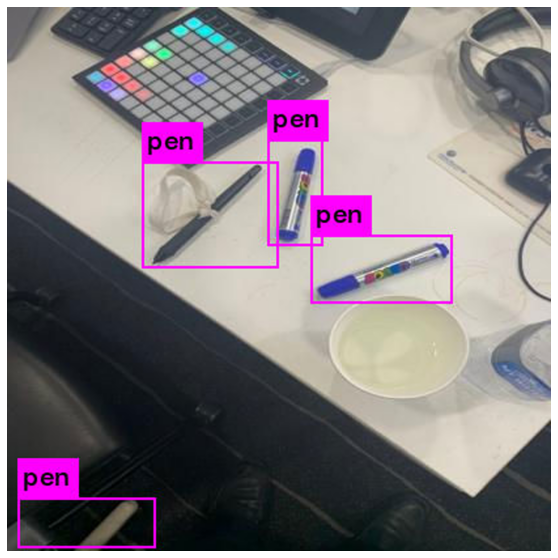

In [9]:

#/test has images that we can test our detector on
test_images = [f for f in os.listdir('test') if f.endswith('.jpg')]
import random
img_path = "test/" + random.choice(test_images);

#test out our detector!
!./darknet detect cfg/custom-yolov4-detector.cfg backup/custom-yolov4-detector_last.weights {img_path} -dont-show
imShow('predictions.jpg')